<a href="https://colab.research.google.com/github/Vizzuality/copernicus-climate-data/blob/master/test_zarr_remote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the copernicus climate project

https://github.com/Vizzuality/copernicus-climate-data

`Edward P. Morris (vizzuality.)`

## Description
This notebook demonstrates functions to calculate heat wave frequency using cloud optimised ZARR datasets.

```
MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Setup

## Linux dependencies

In [0]:
!apt install libspatialindex-dev

## Python packages

In [0]:
!pip install cftime netcdf4 zarr xarray xclim gcsfs nc-time-axis rioxarray

## Authorisation

In [0]:
# For auth WITHOUT service account
#from google.colab import auth
#auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#project_id = "skydipper-196010"
#!gcloud config set project {project_id}

In [0]:
# Copy GC credentials to home (place in your GDrive, and connect Drive)
!cp "/content/drive/My Drive/skydipper-196010-f842645fd0f3.json" "/root/.skydipper-196010-f842645fd0f3.json"

In [14]:
# Auth WITH service account
!gcloud auth activate-service-account \
  edward-morris@skydipper-196010.iam.gserviceaccount.com \
          --key-file=/root/.skydipper-196010-f842645fd0f3.json --project="skydipper-196010"


Activated service account credentials for: [edward-morris@skydipper-196010.iam.gserviceaccount.com]


In [15]:
# Test GC auth
!gsutil ls "gs://copernicus-climate"

gs://copernicus-climate/RH_ERA5.zip
gs://copernicus-climate/mrt_ERA5-HEAT.zip
gs://copernicus-climate/sp_ERA5.zip
gs://copernicus-climate/t2m_ERA5.zip
gs://copernicus-climate/variables_futuro_CMIP5_AEMET.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_3.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_4.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_3.zip
gs://copernicus-climate/ws_ERA5.zip
gs://copernicus-climate/dataset/
gs://copernicus-climate/spain.zarr/


In [16]:
# Clean up
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


# Utils

In [0]:
import gcsfs
import zarr
import xarray as xr
# Set display to HTML sytle (optional)
xr.set_options(display_style='html', display_width=50)

def get_cached_zarr(
    group,
    project_id = "skydipper-196010",
    root = "copernicus-climate/spain.zarr",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  path_or_store = gcsfs.mapping.GCSMap(root, gcs=gc, check=True, create=False)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  #path_or_store = zarr.ZipStore(root, mode='r')
  cache = zarr.LRUStoreCache(path_or_store, max_size=None)
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

# Access ZARRs

In [73]:
%%time
# Here we are only reading the metadata!
seas = get_cached_zarr("seasonal-original-single-levels")
seas

CPU times: user 102 ms, sys: 1.96 ms, total: 104 ms
Wall time: 2.68 s


In [74]:
%%time
# Here we are only reading the metadata!
fut = get_cached_zarr("projections-cmip5-daily-single-levels")
fut

CPU times: user 192 ms, sys: 1.19 ms, total: 193 ms
Wall time: 2.68 s


In [75]:
%%time
# Here we are only reading the metadata!
his = get_cached_zarr("reanalysis-era5-land")
his

CPU times: user 39.5 ms, sys: 823 µs, total: 40.3 ms
Wall time: 2.09 s


# Calculate monthly heatwaves

FIXME: Why do there appear to be no heatwaves (using reasonable limits) in the historical data?

## Future and seasonal

Here the dimensions are (experiment), model, realisation, lat, lon, time 

In [0]:
#%%time
import xclim as xc

def calc_monthly_heat_wave_frequency(ds, thresh_tasmax, thresh_tasmin, window):
  return xc.atmos.heat_wave_frequency(tasmax=ds.tasmax, tasmin=ds.tasmin, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window, freq='MS')

def future_heat_wave_frequency(ds, thresh_tasmax='30 C', thresh_tasmin='26 C', window=2):
  return ds.groupby('model', 'realization')\
  .map(calc_monthly_heat_wave_frequency, args=(thresh_tasmax, thresh_tasmin, window))\
  .mean(['model', 'realization']).squeeze()

#ds = future_heat_wave_frequency(fut, thresh_tasmax='15 C', thresh_tasmin='5 C', window=2)
#ds.sel(experiment='rcp85').isel(time=3).plot()

## Historical

Here the dimensions are lat, lon, time

In [156]:
%%time
import xclim as xc

def calc_monthly_heat_wave_frequency(ds, thresh_tasmax, thresh_tasmin, window):
  return xc.atmos.heat_wave_frequency(tasmax=ds.tasmax, tasmin=ds.tasmin, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window, freq='MS')

def historical_heat_wave_frequency(ds, thresh_tasmax='30 C', thresh_tasmin='26 C', window=2):
  return calc_monthly_heat_wave_frequency(ds, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window).squeeze()

#ds = historical_heat_wave_frequency(his, thresh_tasmax='15 C', thresh_tasmin='5 C', window=2)
#ds.isel(time=3).plot()

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 29.6 µs


## Optimised functions

+ get a time-series for a single lat, long
+ get an array for a single time (month)  

In [0]:
def get_timeseries(ds, lat, lon, type, experiment=None, time_interval=None, thresh_tasmax='30 C', thresh_tasmin='26 C', window=1):
  # select point
  dss = ds.sel(lat=lat, lon=lon, method='nearest').chunk({"time":-1})
  if time_interval:
    dss = dss.sel(time=slice(time_interval[0], time_interval[1]))
  if type == 'future':
    if experiment:
      dss = dss.sel(experiment=experiment)
      out = future_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)
    else:
      out = future_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)  
  if type== 'historical':  
    out = historical_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)
  return out


In [0]:
import json
from dateutil.tz import tzutc

def serialize_date(dt):
    """
    Serialize a date/time value into an ISO8601 text representation
    adjusted (if needed) to UTC timezone.

    For instance:
    >>> serialize_date(datetime(2012, 4, 10, 22, 38, 20, 604391))
    '2012-04-10T22:38:20.604391Z'
    """
    UTC = tzutc()
    try:
      if dt.tzinfo:
        dt = dt.astimezone(UTC).replace(tzinfo=None)
    except:
      pass    

    return dt.isoformat() + 'Z'

def as_json(ds):
  ds['time'] = ds.indexes['time'].to_datetimeindex() 
  d = ds.to_dict()
  d['coords']['time']['data'] = [serialize_date(dt) for dt in d['coords']['time']['data']]
  return json.dumps(d) 


In [0]:
def get_raster(ds, time, type, experiment=None, bbox=None, thresh_tasmax='30 C', thresh_tasmin='26 C', window=1):
  # select bbox
  if bbox:
    ds = ds.sel(lat=slice(bbox[0], bbox[2]), lon=slice(bbox[1], bbox[3]))
  # select time
  dss = ds.sel(time=time, method='nearest').chunk({"lat":-1, "lon":-1})
  if type == 'future':
    if experiment:
      dss = dss.sel(experiment=experiment)
    out = future_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)  
  if type== 'historical':  
    out = historical_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)
  return out

In [0]:
def interpolate_mask_raster(ds_dest, ds_src):
  out = ds_dest.interp(lat=ds_src['lat'], lon=ds_src['lon'])
  return out.where(ds_src > -1.0)

In [0]:
import rioxarray
def create_cog(ds, p):
  ds.rio.set_spatial_dims('lon', 'lat')
  ds.rio.to_raster(p, **{
        "driver": "GTiff",
        "interleave": "pixel",
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
        "compress": "WEBP"
        })
  print(f"COG written to {p}")

### Get time series

CPU times: user 6.36 s, sys: 276 ms, total: 6.63 s
Wall time: 5.32 s


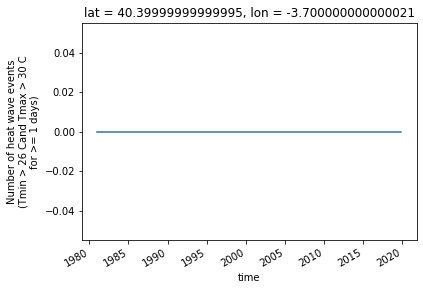

In [201]:
%%time
# Historical
ds = get_timeseries(his, 40.411335, -3.674908, 'historical')
ds.plot()

CPU times: user 1.54 s, sys: 121 ms, total: 1.66 s
Wall time: 1.46 s


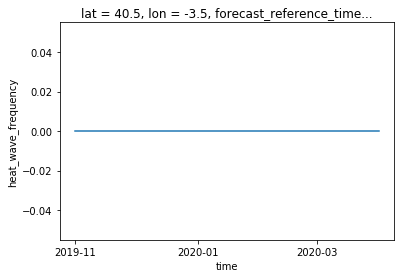

In [202]:
%%time
# Seasonal
ds = get_timeseries(seas, 40.411335, -3.674908, 'future')
ds.plot()

CPU times: user 1min 16s, sys: 2.87 s, total: 1min 19s
Wall time: 1min 17s


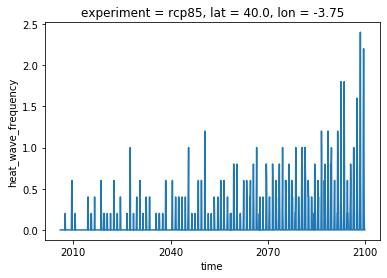

In [203]:
%%time
# this takes longer as it creates mean of n models and n realizations!
# Future
ds = get_timeseries(fut, 40.411335, -3.674908, 'future', experiment='rcp85')
ds.plot()

In [249]:
# As JSON selecting time interval
%%time
#
import pprint
# Historical
ds = get_timeseries(fut, 40.411335, -3.674908, 'future', experiment='rcp85', time_interval=['2090', '2091'])
pprint.pprint(as_json(ds))

('{"dims": ["time"], "attrs": {}, "data": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, '
 '0.6, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 1.2, 0.8, 0.0, '
 '0.0, 0.0], "coords": {"experiment": {"dims": [], "attrs": {}, "data": '
 '"rcp85"}, "lat": {"dims": [], "attrs": {"axis": "Y", "bounds": "lat_bnds", '
 '"long_name": "latitude", "standard_name": "latitude", "stored_direction": '
 '"increasing", "type": "double", "units": "degrees_north", "valid_max": 90.0, '
 '"valid_min": -90.0}, "data": 40.0}, "lon": {"dims": [], "attrs": {"axis": '
 '"X", "bounds": "lon_bnds", "long_name": "longitude", "standard_name": '
 '"longitude", "stored_direction": "increasing", "type": "double", "units": '
 '"degrees_east", "valid_max": 360.0, "valid_min": -180.0}, "data": -3.75}, '
 '"time": {"dims": ["time"], "attrs": {}, "data": ["2090-01-01T00:00:00Z", '
 '"2090-02-01T00:00:00Z", "2090-03-01T00:00:00Z", "2090-04-01T00:00:00Z", '
 '"2090-05-01T00:00:00Z", "2090-06-01T00:00:00Z", "2090-07-01T00:00:

### Get raster

CPU times: user 294 ms, sys: 9.87 ms, total: 304 ms
Wall time: 274 ms


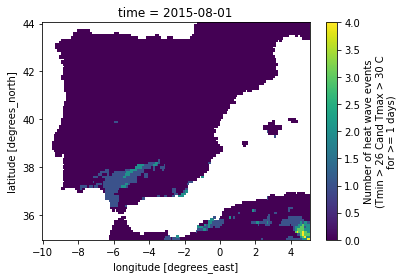

In [238]:
%%time
# Historical
ds = get_raster(his, '2015-08', 'historical')
ds.plot()

CPU times: user 237 ms, sys: 7.32 ms, total: 244 ms
Wall time: 208 ms


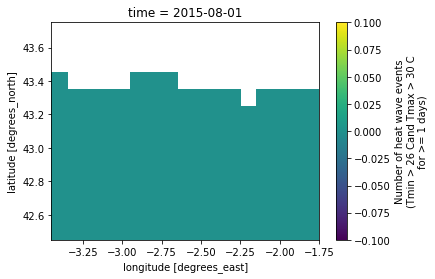

In [206]:
%%time
# Historical
bbox = [42.4714,-3.4503,43.7598,-1.7293]
ds = get_raster(his, '2015-08', 'historical', bbox=bbox)
ds.plot()

COG written to test-cog.tif


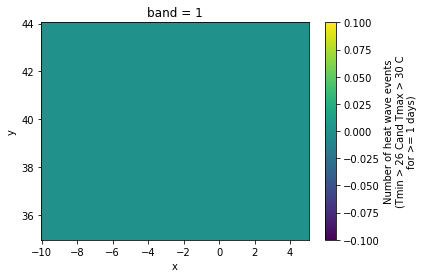

In [239]:
# Export a COG
# FIXME: find how to ensure NA values are handled correctly
import rioxarray
ds = get_raster(his, '2015-08', 'historical')
cog_url = 'test-cog.tif'
create_cog(ds, 'test-cog.tif')
rds = rioxarray.open_rasterio(cog_url, mask_and_scale=True)
rds
rds.plot()

CPU times: user 6.5 s, sys: 1.7 s, total: 8.19 s
Wall time: 5.95 s


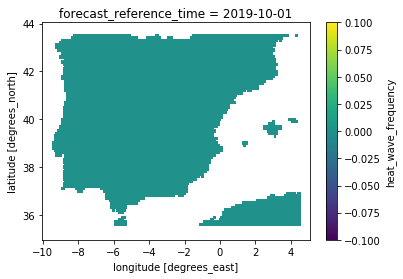

In [191]:
%%time
# Seasonal
ds = get_raster(seas, '2020-02', 'future')
ds_src = get_raster(his, '2015-08', 'historical')
ds = interpolate_mask_raster(ds, ds_src)
ds.plot()

CPU times: user 1 s, sys: 25.7 ms, total: 1.03 s
Wall time: 900 ms


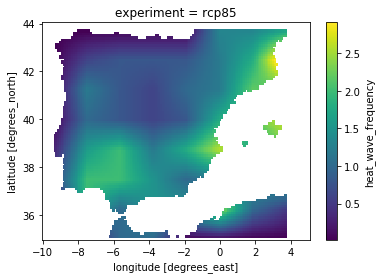

In [192]:
%%time
# Future
ds = get_raster(fut, '2090-08', 'future', experiment='rcp85')
ds_src = get_raster(his, '2015-08', 'historical')
ds = interpolate_mask_raster(ds, ds_src)
ds.plot()